#### References
- Referenced Paper: What Does BERT Look AT? An Analysis of BERT's Attention [Kevin Clark et.al]
- Code reference github: https://github.com/clarkkev/attention-analysis

In [1]:
import collections
import pickle
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

In [28]:
from transformers import BartTokenizer, BartForConditionalGeneration
import torch
from bertviz import model_view, head_view 

import matplotlib.pyplot as plt

from IPython.display import display, HTML

model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn", output_attentions=True)
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

ARTICLE_TO_SUMMARIZE = "Alternatively, you can generate multiple random sentences and try to fit them all into a single story. For instance, you could generate three sentences and use one to start your story; one for the midpoint; and one to finish off your final paragraph. Or if you want to mix things up even more, you can check out our Random Letter Generator tool, which you can use to generate different types of random writing prompts."
# ARTICLE_TO_SUMMARIZE = "The complicated language in the huge new law has ruined the fight."

def bart_summarize(text, num_beams, length_penalty, max_length, min_length, no_repeat_ngram_size):
    text = text.replace('\n', '')
    text_input_ids = tokenizer.batch_encode_plus([text], return_tensors = 'pt', max_length=1024)['input_ids'].to(device)
    summary_ids = model.generate(text_input_ids, num_beams = int(num_beams), length_penalty = float(length_penalty), max_length = int(max_length), min_length=int(min_length), no_repeat_ngram_size = int(no_repeat_ngram_size)) 
    
    summary_txt = tokenizer.decode(summary_ids.squeeze(), skip_special_tokens = True)
    return summary_txt


def get_attention_tokens(text):
    inputs = tokenizer.encode(text, return_tensors = 'pt').to(device)
    outputs = model(inputs)
    attention = outputs[-1]
    cross_attention = outputs.cross_attentions
    encoder_attention = outputs.encoder_attentions
    decoder_attention = outputs.decoder_attentions
    tokens = tokenizer.convert_ids_to_tokens(inputs[0]) 
    
    return attention, encoder_attention, decoder_attention, cross_attention, tokens
 

attention, encoder_attention, decoder_attention, cross_attention, tokens = get_attention_tokens(ARTICLE_TO_SUMMARIZE)





In [29]:
new_tokens = []
for token in tokens:
    if token == "<s>":
        token = "[CLS]"
    elif token == "</s>":
        token = "[SEP]"
    
    new_tokens.append(token)

In [30]:
new_tokens

['[CLS]',
 'Alternatively',
 ',',
 'Ġyou',
 'Ġcan',
 'Ġgenerate',
 'Ġmultiple',
 'Ġrandom',
 'Ġsentences',
 'Ġand',
 'Ġtry',
 'Ġto',
 'Ġfit',
 'Ġthem',
 'Ġall',
 'Ġinto',
 'Ġa',
 'Ġsingle',
 'Ġstory',
 '.',
 'ĠFor',
 'Ġinstance',
 ',',
 'Ġyou',
 'Ġcould',
 'Ġgenerate',
 'Ġthree',
 'Ġsentences',
 'Ġand',
 'Ġuse',
 'Ġone',
 'Ġto',
 'Ġstart',
 'Ġyour',
 'Ġstory',
 ';',
 'Ġone',
 'Ġfor',
 'Ġthe',
 'Ġmid',
 'point',
 ';',
 'Ġand',
 'Ġone',
 'Ġto',
 'Ġfinish',
 'Ġoff',
 'Ġyour',
 'Ġfinal',
 'Ġparagraph',
 '.',
 'ĠOr',
 'Ġif',
 'Ġyou',
 'Ġwant',
 'Ġto',
 'Ġmix',
 'Ġthings',
 'Ġup',
 'Ġeven',
 'Ġmore',
 ',',
 'Ġyou',
 'Ġcan',
 'Ġcheck',
 'Ġout',
 'Ġour',
 'ĠRandom',
 'ĠLetter',
 'ĠGenerator',
 'Ġtool',
 ',',
 'Ġwhich',
 'Ġyou',
 'Ġcan',
 'Ġuse',
 'Ġto',
 'Ġgenerate',
 'Ġdifferent',
 'Ġtypes',
 'Ġof',
 'Ġrandom',
 'Ġwriting',
 'Ġprompts',
 '.',
 '[SEP]']

In [31]:

_attention = torch.stack(list(attention), dim=0)


In [32]:
_attention = _attention.squeeze(1)
attns = _attention.detach().cpu().numpy()

In [33]:

data = {
    "tokens" : new_tokens,
    "attns" : attns
}

In [34]:
n_docs = 1

In [35]:
def data_iterator():
  for i, doc in enumerate(data):
    if i % 100 == 0 or i == len(data) - 1:
      print("{:.1f}% done".format(100.0 * (i + 1) / len(data)))
    yield data["tokens"], np.array(data["attns"])

In [36]:
 avg_attns = {
    k: np.zeros((12, 16)) for k in [
      "self", "right", "left", "sep", "sep_sep", "rest_sep",
      "cls", "punct"]
}

print("Computing token stats")
for tokens, attns in data_iterator():
  n_tokens = attns.shape[-1]

  # create masks indicating where particular tokens are
  seps, clss, puncts = (np.zeros(n_tokens) for _ in range(3))
  for position, token in enumerate(tokens):
    if token == "[SEP]":
      seps[position] = 1
    if token == "[CLS]":
      clss[position] = 1
    if token == "." or token == ",":
      puncts[position] = 1

  # create masks indicating which positions are relevant for each key
  sep_seps = np.ones((n_tokens, n_tokens))
  sep_seps *= seps[np.newaxis]
  sep_seps *= seps[:, np.newaxis]

  rest_seps = np.ones((n_tokens, n_tokens))
  rest_seps *= (np.ones(n_tokens) - seps)[:, np.newaxis]
  rest_seps *= seps[np.newaxis]

  selectors = {
      "self": np.eye(n_tokens, n_tokens),
      "right": np.eye(n_tokens, n_tokens, 1),
      "left": np.eye(n_tokens, n_tokens, -1),
      "sep": np.tile(seps[np.newaxis], [n_tokens, 1]),
      "sep_sep": sep_seps,
      "rest_sep": rest_seps,
      "cls": np.tile(clss[np.newaxis], [n_tokens, 1]),
      "punct": np.tile(puncts[np.newaxis], [n_tokens, 1]),
  }

  # get the average attention for each token type
  for key, selector in selectors.items():
    if key == "sep_sep":
      denom = 2
    elif key == "rest_sep":
      denom = n_tokens - 2
    else:
      denom = n_tokens
    avg_attns[key] += (
        (attns * selector[np.newaxis, np.newaxis]).sum(-1).sum(-1) /
        (n_docs * denom))

Computing token stats
50.0% done
100.0% done


In [37]:
uniform_attn_entropy = 0  # entropy of uniform attention
entropies = np.zeros((12, 16))  # entropy of attention heads
entropies_cls = np.zeros((12, 16))  # entropy of attention from [CLS]

print("Computing entropy stats")
for tokens, attns in data_iterator():
  attns = 0.9999 * attns + (0.0001 / attns.shape[-1])  # smooth to avoid NaNs
  uniform_attn_entropy -= np.log(1.0 / attns.shape[-1])
  entropies -= (attns * np.log(attns)).sum(-1).mean(-1)
  entropies_cls -= (attns * np.log(attns))[:, :, 0].sum(-1)

uniform_attn_entropy /= n_docs
entropies /= n_docs
entropies_cls /= n_docs

Computing entropy stats
50.0% done
100.0% done


In [38]:
# Pretty colors
BLACK = "k"
GREEN = "#59d98e"
SEA = "#159d82"
BLUE = "#3498db"
PURPLE = "#9b59b6"
GREY = "#95a5a6"
RED = "#e74c3c"
ORANGE = "#f39c12"

In [39]:
def get_data_points(head_data):
  xs, ys, avgs = [], [], []
  for layer in range(12):
    for head in range(16):
      ys.append(head_data[layer, head])
      xs.append(1 + layer)
    avgs.append(head_data[layer].mean())
  return xs, ys, avgs

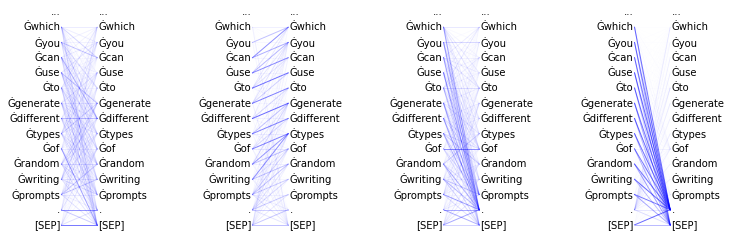

In [40]:
width = 3
example_sep = 5
word_height = 1
pad = 0.1


def plot_attn(example, heads):
  """Plots attention maps for the given example and attention heads."""

  for ei, (layer, head) in enumerate(heads):
    yoffset = 1
    xoffset = ei * width * example_sep

    attn = example["attns"][layer][head][-15:, -15:]
    attn = np.array(attn)
    attn /= attn.sum(axis=-1, keepdims=True)
    words = example["tokens"][-15:]
    words[0] = "..."
    n_words = len(words)

    for position, word in enumerate(words):
      plt.text(xoffset + 0, yoffset - position * word_height, word,
               ha="right", va="center")
      plt.text(xoffset + width, yoffset - position * word_height, word,
               ha="left", va="center")
    for i in range(1, n_words):
      for j in range(1, n_words):
        plt.plot([xoffset + pad, xoffset + width - pad],
                 [yoffset - word_height * i, yoffset - word_height * j],
                 color="blue", linewidth=1, alpha=attn[i, j])

plt.figure(figsize=(12, 4))
plt.axis("off")
plot_attn(data, [(0, 0), (2, 0), (7, 6), (10, 5)])
plt.show()

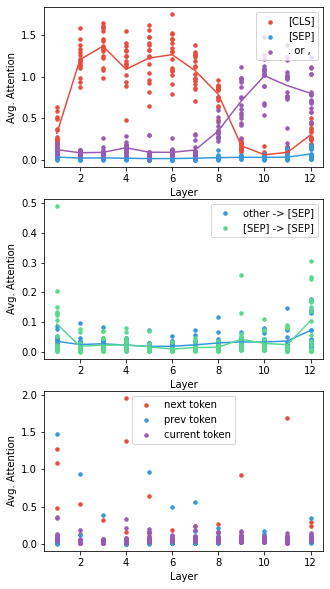

In [41]:
def add_line(key, ax, color, label, plot_avgs=True):
  xs, ys, avgs = get_data_points(avg_attns[key])
  ax.scatter(xs, ys, s=12, label=label, color=color)
  if plot_avgs:
    ax.plot(1 + np.arange(len(avgs)), avgs, color=color)
  ax.legend(loc="best")
  ax.set_xlabel("Layer")
  ax.set_ylabel("Avg. Attention")


plt.figure(figsize=(5, 10))
ax = plt.subplot(3, 1, 1)
for key, color, label in [
    ("cls", RED, "[CLS]"),
    ("sep", BLUE, "[SEP]"),
    ("punct", PURPLE, ". or ,"),
]:
  add_line(key, ax, color, label)

ax = plt.subplot(3, 1, 2)
for key, color, label in [
    ("rest_sep", BLUE, "other -> [SEP]"),
    ("sep_sep", GREEN, "[SEP] -> [SEP]"),
]:
  add_line(key, ax, color, label)

ax = plt.subplot(3, 1, 3)
for key, color, label in [
    ("left", RED, "next token"),
    ("right", BLUE, "prev token"),
    ("self", PURPLE, "current token"),
]:
  add_line(key, ax, color, label, plot_avgs=False)

 

plt.show()

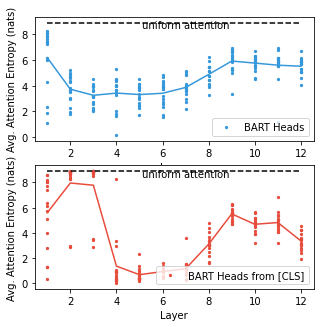

In [42]:
xs, es, avg_es = get_data_points(entropies)
xs, es_cls, avg_es_cls = get_data_points(entropies_cls)

plt.figure(figsize=(5, 5))


def plot_entropies(ax, data, avgs, label, c):
  ax.scatter(xs, data, c=c, s=5, label=label)
  ax.plot(1 + np.arange(12), avgs, c=c)
  ax.plot([1, 12], [uniform_attn_entropy, uniform_attn_entropy],
          c="k", linestyle="--")
  ax.text(7, uniform_attn_entropy - 0.45, "uniform attention",
          ha="center")
  ax.legend(loc="lower right")
  ax.set_ylabel("Avg. Attention Entropy (nats)")
  ax.set_xlabel("Layer")

plot_entropies(plt.subplot(2, 1, 1), es, avg_es, "BART Heads",
               c=BLUE)
plot_entropies(plt.subplot(2, 1, 2), es_cls, avg_es_cls,
               "BART Heads from [CLS]", c=RED)

plt.show()

> In the paper, they mention that the entropies the last layer is high indicating broad attnetion in the last layers. 
Here we can see that the first layers have higher entropies than the lower layers. This may indicate that the BART model have broder attention in the earlier layers. 

In [43]:
attns = _attention.detach().cpu().numpy()

In [44]:
js_distances = np.zeros([192, 192])

In [45]:
attns_flat = attns.reshape([192, attns.shape[2], attns.shape[3]]) 

In [46]:
attns_flat.shape

(192, 86, 86)

In [47]:
 for head in range(192):
      head_attns = np.expand_dims(attns_flat[head], 0)
      head_attns_smoothed = (0.001 / head_attns.shape[1]) + (head_attns * 0.999)
      attns_flat_smoothed = (0.001 / attns_flat.shape[1]) + (attns_flat * 0.999)
      m = (head_attns_smoothed + attns_flat_smoothed) / 2
      js = -head_attns_smoothed * np.log(m / head_attns_smoothed)
      js += -attns_flat_smoothed * np.log(m / attns_flat_smoothed)
      js /= 2
      js = js.sum(-1).sum(-1)
      js_distances[head] += js

In [48]:
js_distances

array([[ 0.        , 12.52800274, 19.3507843 , ..., 22.37776375,
        22.75873756, 24.22917366],
       [12.52800274,  0.        , 16.82952499, ..., 23.7458477 ,
        26.73792648, 28.3041153 ],
       [19.3507843 , 16.82952499,  0.        , ..., 21.36388397,
        30.59692955, 30.95444298],
       ...,
       [22.37776375, 23.7458477 , 21.36388397, ...,  0.        ,
        16.08681488, 16.21538162],
       [22.75873756, 26.73792648, 30.59692955, ..., 16.08681488,
         0.        , 12.17153358],
       [24.22917366, 28.3041153 , 30.95444298, ..., 16.21538162,
        12.17153358,  0.        ]])

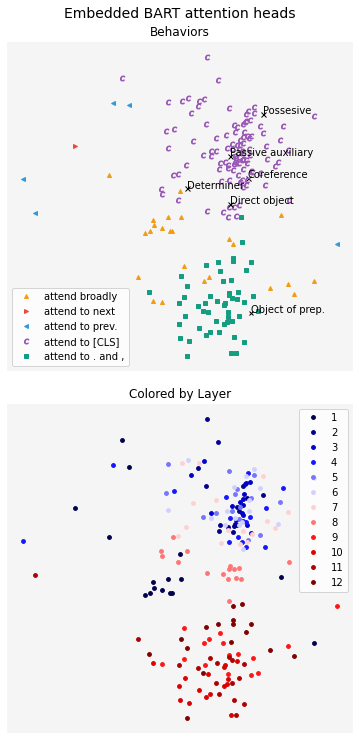

In [49]:
from sklearn.manifold import MDS
from matplotlib import cm

ENTROPY_THRESHOLD = 3.8  # When to say a head "attends broadly"
POSITION_THRESHOLD = 0.5  # When to say a head "attends to next/prev"
SPECIAL_TOKEN_THRESHOLD = 0.6  # When to say a heads attends to [CLS]/[SEP]"
# Heads that were found to have linguistic behaviors
LINGUISTIC_HEADS = {
    (4, 3): "Coreference",
    (7, 10): "Determiner",
    (7, 9): "Direct object",
    (8, 5): "Object of prep.",
    (3, 9): "Passive auxiliary",
    (6, 5): "Possesive",
}

# Use multi-dimensional scaling to compute 2-dimensional embeddings that
# reflect Jenson-Shannon divergences between attention heads.
mds = MDS(metric=True, n_init=5, n_jobs=4, eps=1e-10,
                           max_iter=1000, dissimilarity="precomputed")
pts = mds.fit_transform(js_distances)
pts = pts.reshape((12, 16, 2))
pts_flat = pts.reshape([192, 2])

colormap = cm.seismic(np.linspace(0, 1.0, 12))
plt.figure(figsize=(4.8, 9.6))
plt.title("BERT Attention Heads")

for color_by_layer in [False, True]:
  ax = plt.subplot(2, 1, int(color_by_layer) + 1)
  seen_labels = set()
  for layer in range(12):
    for head in range(16):
      label = ""
      color = GREY
      marker = "o"
      markersize = 4
      x, y = pts[layer, head]

      if avg_attns["right"][layer, head] > POSITION_THRESHOLD:
        color = RED
        marker = ">"
        label = "attend to next"
        
      if avg_attns["left"][layer, head] > POSITION_THRESHOLD:
        color = BLUE
        label = "attend to prev."
        marker = "<"

      if entropies[layer, head] > ENTROPY_THRESHOLD:
        color = ORANGE
        label = "attend broadly"
        marker = "^"

      if avg_attns["cls"][layer, head] > SPECIAL_TOKEN_THRESHOLD:
        color = PURPLE
        label = "attend to [CLS]"
        marker = "$C$"
        markersize = 5

      if avg_attns["sep"][layer, head] > SPECIAL_TOKEN_THRESHOLD:
        color = GREEN
        marker = "$S$"
        markersize = 5
        label = "attend to [SEP]"

      if avg_attns["punct"][layer, head] > SPECIAL_TOKEN_THRESHOLD:
        color = SEA
        marker = "s"
        markersize = 3.2
        label = "attend to . and ,"

      if color_by_layer:
        label = str(layer + 1)
        color = colormap[layer]
        marker = "o"
        markersize = 3.8

      if not color_by_layer:
        if (layer, head) in LINGUISTIC_HEADS:
          label = ""
          color = BLACK
          marker = "x"
          ax.text(x, y, LINGUISTIC_HEADS[(layer, head)], color=color)

      if label not in seen_labels:
        seen_labels.add(label)
      else:
        label = ""

      ax.plot([x], [y], marker=marker, markersize=markersize,
              color=color, label=label, linestyle="")

  ax.set_xticks([])
  ax.set_yticks([])
  ax.spines["top"].set_visible(False)
  ax.spines["right"].set_visible(False)
  ax.spines["bottom"].set_visible(False)
  ax.spines["left"].set_visible(False)
  ax.set_facecolor((0.96, 0.96, 0.96))
  plt.title(("Colored by Layer" if color_by_layer else "Behaviors"))
  handles, labels = ax.get_legend_handles_labels()
  ax.legend(handles, labels, loc="best")

plt.suptitle("Embedded BART attention heads", fontsize=14, y=1.05)
plt.subplots_adjust(top=1, bottom=0, right=1, left=0,
                    hspace=0.1, wspace=0)
plt.show()